In [1]:
%load_ext autoreload
%autoreload 2

### Imports

In [2]:
import json
from IPython.display import Image
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
import seaborn as sns
import time
from tqdm import tqdm
from typing import List
#from typing import Union

from pykeen.evaluation import RankBasedEvaluator
from pykeen.triples import TriplesFactory
import toml
import torch

/home/jovyan/.conda/envs/bioblp-env/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [138]:
from nb_utils.eval_utils import TEST, VALID, TRAIN, DUMMY
from nb_utils.eval_utils import EVAL_METRICS_CATALOG, EVAL_METRICS_SHORTLIST
from nb_utils.eval_utils import COL_SOURCE, COL_TARGET, COL_EDGE, COL_NODE, DEGREE, IN_DEGREE, OUT_DEGREE
from nb_utils.eval_utils import create_entity_attr_aware_test_sets
from nb_utils.eval_utils import setup_wandb_result_tracker, run_experiment_and_log_wandb
from nb_utils.eval_utils import compute_node_degrees_in_out
from nb_utils.eval_utils import load_kge_model
from nb_utils.eval_utils import create_entity_attr_aware_test_sets
from nb_utils.eval_utils import make_results_dict_all_rel


from nb_utils.config import ARTIFACT_REGISTRY_TOML_PATH, EntityType
from nb_utils.config import load_toml, ModelRegistryConfig, EvaluationConfig
from nb_utils.config import GraphRegistryConfig, EntityType
from nb_utils.config import PROTEIN, DRUG, DISEASE
from nb_utils.eval_utils import ENT_ASSOC_REL_NAMES, EVAL_METRIC_REALISTIC, EVAL_NODE_HEAD, EVAL_NODE_TAIL
from nb_utils.eval_utils import PROT_ASSOC_REL_NAMES, test_rel_list_validity, ENT_ASSOC_REL_NAMES
from nb_utils.eval_utils import TEST, TRAIN, VALID, DUMMY
from nb_utils.eval_utils import TEST_RESTRICTED_PROT, TEST_RESTRICTED_DIS, TEST_RESTRICTED_DRUG
from nb_utils.eval_utils import ENT_SPECIFIC_TEST_SET_STUBS

ImportError: cannot import name 'TEST_RESTRICTED_PROT' from 'nb_utils.eval_utils' (/home/jovyan/BioBLP/notebooks/nb_utils/eval_utils.py)

### load data

1. add the paths to the following models and biokg files in ./nb_utils/artifact_registry.toml
2. 

In [93]:
ROTATE = "rotate-otxtubeb"
BIOBLP_D = "bioblpd-38uz9fjs-16-03-2023" 
BIOBLP_D_old = "bioblpd-38uz9fjs" 
BIOBLP_P = "bioblpp-cttc3ucm"
BIOBLP_M = "bioblpm-5rxz3k57"

In [94]:
toml_path = ARTIFACT_REGISTRY_TOML_PATH
model_reg_cfg = ModelRegistryConfig.from_toml(toml_path)
model_registry_paths = model_reg_cfg.registered_model_paths
model_training_paths = model_reg_cfg.registered_model_training_triples_paths

In [95]:
graph_cfg = GraphRegistryConfig.from_toml(ARTIFACT_REGISTRY_TOML_PATH)
graph_cfg

GraphRegistryConfig(biokgb_data_splits={'train': PosixPath('../data/biokgb/graph/biokg.links-train.csv'), 'valid': PosixPath('../data/biokgb/graph/biokg.links-valid.csv'), 'test': PosixPath('../data/biokgb/graph/biokg.links-test.csv'), 'dummy': PosixPath('../data/biokgb/graph/biokg.links-dummy.csv')}, biokgb_entity_type_metadata_paths={'disease': PosixPath('../data/biokgb/properties/biokg.metadata.disease.tsv'), 'protein': PosixPath('../data/biokgb/properties/biokg.metadata.protein.tsv'), 'drug': PosixPath('../data/biokgb/properties/biokg.metadata.drug.tsv'), 'pathway': PosixPath('../data/biokgb/properties/biokg.metadata.pathway.tsv'), 'genetic_disorder': PosixPath('../data/biokgb/properties/biokg.metadata.genetic_disorder.tsv')}, biokgb_entity_attribute_paths={'disease': PosixPath('../data/biokgb/properties/biokg_meshid_to_descr_name.tsv'), 'protein': PosixPath('../data/biokgb/properties/protein_embeddings_full_24_12_protid_idx_mapping.json'), 'drug': PosixPath('../data/biokgb/propert

## SET CONFIG

In [45]:
MODEL_ID = ROTATE  # BIOBLP_D
ENTITY_TYPE_W_ATTR_ENCODE = DISEASE  # EntityType{Disease}.value

### load triples data

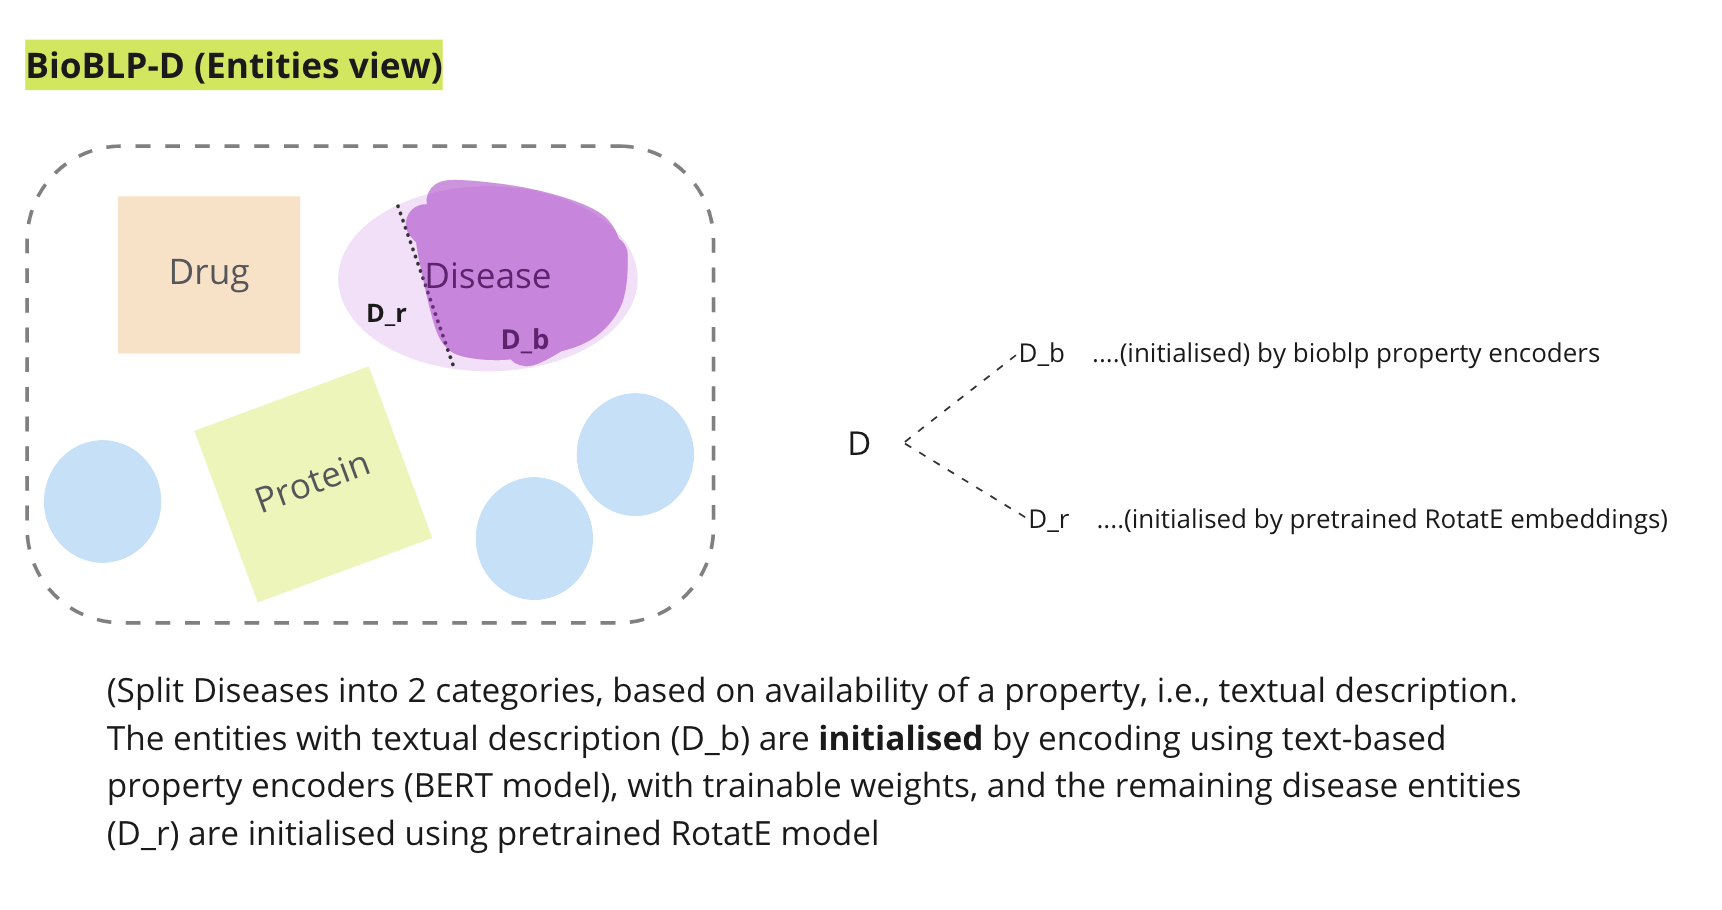

In [16]:
from IPython.display import Image
Image('data/imgs/eval_split_entity_view.png', width=500)

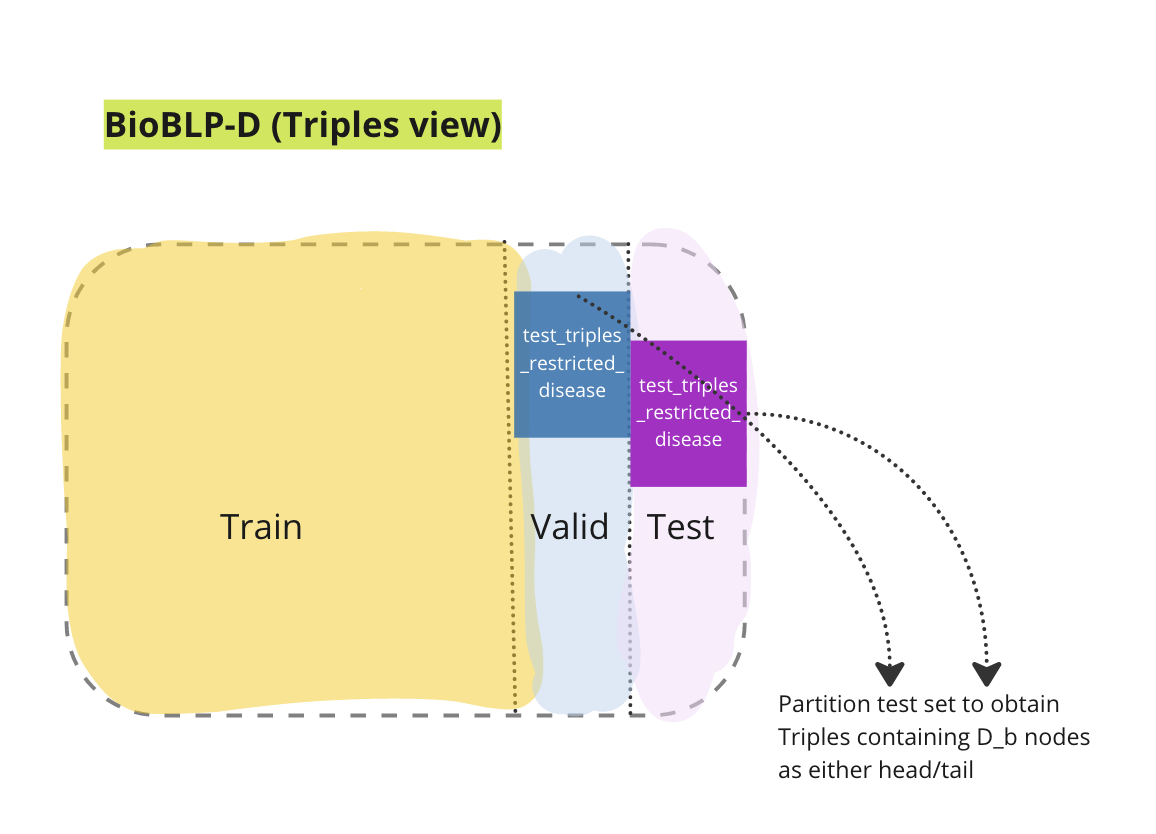

In [17]:
# The figure below demonstrates how we obtain the various test sets
Image('data/imgs/eval_split_triples_view.png', width=450)

In [119]:
# load training splits
train = TriplesFactory.from_path_binary(model_training_paths[MODEL_ID])


valid, test, dummy = [TriplesFactory.from_path(f,
                                               entity_to_id=train.entity_to_id,
                                               relation_to_id=train.relation_to_id)
               for f in (map(graph_cfg.biokgb_data_splits.get, [VALID, TEST, DUMMY]))]


creating a dummy set of triples for unit testing purposes

In [120]:
dummy_triples_path = graph_cfg.biokgb_data_splits[DUMMY]
if not dummy_triples_path.exists:
    print(f'Slicing test triples to create a batch of dummy triples and saving to {str(dummy_triples_path)}')
    dummy_df = pd.read_csv(graph_path.joinpath(test_triples), sep="\t", header=None)[:50]
    dummy_df.to_csv(dummy_triples_path, sep="\t", index=None, header=None)

In [139]:
triples_dict = {
    TEST: test,
    VALID: valid,
    TRAIN: train,    
    DUMMY: dummy, 
}

#TEST_SET_LIST = [TEST, VALID] 


#### Split test triples conditional on whether they contain entities whose properties were encoded in BIOBLP-X vs not

In [140]:
LIST_ENTITY_TYPES_W_ATTRIBUTE = [DRUG, PROTEIN, DISEASE]

for ent_type in LIST_ENTITY_TYPES_W_ATTRIBUTE:
    print(f"Creating test sets with triples restricted to containing {ent_type}")
    test_triples_incl_ent_prop, test_triples_excl_ent_prop = create_entity_attr_aware_test_sets(entity_type_w_attribute=ent_type,
                                                                                            graph_cfg=graph_cfg,
                                                                                            train=train,
                                                                                            test=test) 
    triples_dict.update({ENT_SPECIFIC_TEST_SET_STUBS[ent_type]: test_triples_incl_ent_prop})
    
    
triples_dict.keys()

Creating test sets with triples restricted to containing drug


Reconstructing all label-based triples. This is expensive and rarely needed.


# drug entities in larger biokg (pre-benchmark removal): 13580
# drug entities for which we have attributes: 10815


Reconstructing all label-based triples. This is expensive and rarely needed.


Creating test sets with triples restricted to containing protein
# protein entities in larger biokg (pre-benchmark removal): 122902
# protein entities for which we have attributes: 121988


Reconstructing all label-based triples. This is expensive and rarely needed.
Reconstructing all label-based triples. This is expensive and rarely needed.
Reconstructing all label-based triples. This is expensive and rarely needed.


Creating test sets with triples restricted to containing disease
# disease entities in larger biokg (pre-benchmark removal): 11347
# disease entities for which we have attributes: 11347


Reconstructing all label-based triples. This is expensive and rarely needed.


dict_keys(['test', 'valid', 'train', 'dummy', 'TEST_RESTRICTED_DRUG', 'TEST_RESTRICTED_PROTEIN', 'TEST_RESTRICTED_DISEASE'])

In [46]:
# check relations are present in train set
test_rel_list_validity(ENT_ASSOC_REL_NAMES[ENTITY_TYPE_W_ATTR_ENCODE][COL_TARGET], train)
test_rel_list_validity(ENT_ASSOC_REL_NAMES[ENTITY_TYPE_W_ATTR_ENCODE][COL_SOURCE], train)


In [142]:
# create set of triples
print(f"# triples originally in test: {test.num_triples}, valid: {valid.num_triples}")
for ent_type in LIST_ENTITY_TYPES_W_ATTRIBUTE:
    print(f"# test triples with {ent_type} nodes: {triples_dict[ENT_SPECIFIC_TEST_SET_STUBS[ent_type]].num_triples}")


# triples originally in test: 185227, valid: 185226
# test triples with drug nodes: 123636
# test triples with protein nodes: 54064
# test triples with disease nodes: 17063


# Evaluation

wandb logging

In [15]:
import wandb
wandb.login()

WANDB_ENTITY_DISCOVERYLAB = "discoverylab"
WANDB_PROJECT_NAME = "bioblp-jupyter-eval"


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: pmitra01 (discoverylab). Use `wandb login --relogin` to force relogin


sanity check logic for experiment run with wandb logging

In [55]:
def trial_func(x=1, y=2):
    print(x*y)
    return {'x': x, 'y':y}

#trial_func_kwargs = {"x": 1, "y": 2} 
#metrics = run_experiment('dummy-run', TEST, BIOBLP_D, trial_func, **trial_func_kwargs) 

Triples with protein as src entity far outnumber triples with protein as tail entity. 


### average performance predicting the node which has an entity degree of x

Let's focus only relation types where proteins are the source, as these have more support in the train/test sets

In [39]:
df = pd.DataFrame(test_triples_incl_ent_prop.triples, columns=[COL_SOURCE, COL_EDGE, COL_TARGET])
df[:2]
df[COL_EDGE].value_counts()

Reconstructing all label-based triples. This is expensive and rarely needed.


PROTEIN_DISEASE_ASSOCIATION    9760
DRUG_DISEASE_ASSOCIATION       6749
DISEASE_PATHWAY_ASSOCIATION     293
DISEASE_GENETIC_DISORDER        261
Name: rel, dtype: int64

#### exploratory peek into transformed data and distributions

In [145]:
from nb_utils.eval_utils import NodeDegreeEvalAnalyser
ENTITY_TYPE_W_ATTR_ENCODE = DISEASE
test_triples_incl_ent_prop = triples_dict.get(ENT_SPECIFIC_TEST_SET_STUBS.get(ENTITY_TYPE_W_ATTR_ENCODE))

nde_ = NodeDegreeEvalAnalyser(train_triples=train,
                           rels_assoc_by_node_endpoint_type_dict=ENT_ASSOC_REL_NAMES)

test_triples_ent_w_attr_df = nde_.prep_test_data(test_triples_incl_ent_prop)

test_triples_by_node_endpoint_to_predict = {
    node_endpoint: nde_._create_test_df_subset_given_node_endpoint_type_to_predict(
        test_df=test_triples_ent_w_attr_df, 
        entity_type_to_predict = ENTITY_TYPE_W_ATTR_ENCODE,
        node_endpoint_to_predict=node_endpoint,
    ) for node_endpoint in [COL_SOURCE, COL_TARGET]
}

Reconstructing all label-based triples. This is expensive and rarely needed.
Reconstructing all label-based triples. This is expensive and rarely needed.


In [146]:
# we see the count of triples where the {ENTITY_TYPE_W_ATTR_ENCODE} occurs as the head/src vs tail/tgt
triples_by_node_endpoint = {node_endpoint: len(test_triples_by_node_endpoint_to_predict[node_endpoint]) for node_endpoint in [COL_SOURCE, COL_TARGET]}
triples_by_node_endpoint

{'src': 16509, 'tgt': 554}

In [147]:
print(f"Counts of triples with {ENTITY_TYPE_W_ATTR_ENCODE} in src/tgt position {triples_by_node_endpoint}")
print(f"i.e.,{round((triples_by_node_endpoint[COL_SOURCE])/(triples_by_node_endpoint[COL_TARGET]+triples_by_node_endpoint[COL_SOURCE])*100, 2)}% test triples with {ENTITY_TYPE_W_ATTR_ENCODE} occuring in source position than in tail position")

Counts of triples with disease in src/tgt position {'src': 16509, 'tgt': 554}
i.e.,96.75% test triples with disease occuring in source position than in tail position


In [66]:
NODE_ENDPOINT_TO_PREDICT = COL_SOURCE
print(f"Restricting analysis to relations where we predict '{ENTITY_TYPE_W_ATTR_ENCODE}' as '{NODE_ENDPOINT_TO_PREDICT}'")

Restricting analysis to relations where we predict 'disease' as 'src'


In [63]:
rels_for_ent_w_attr_as_src = ENT_ASSOC_REL_NAMES[ENTITY_TYPE_W_ATTR_ENCODE][COL_SOURCE]
test_triples_ent_w_attr_df[test_triples_ent_w_attr_df[COL_EDGE].isin(rels_for_ent_w_attr_as_src)][f'{COL_SOURCE}_training_degree'].describe()

count    16509.000000
mean       340.994972
std        483.923354
min          1.000000
25%         16.000000
50%         54.000000
75%        650.000000
max       1942.000000
Name: src_training_degree, dtype: float64

In [64]:
rels_w_prot_as_tgt = ENT_ASSOC_REL_NAMES[ENTITY_TYPE_W_ATTR_ENCODE][COL_TARGET]
test_triples_ent_w_attr_df[test_triples_ent_w_attr_df[COL_EDGE].isin(rels_w_prot_as_tgt)][f'{COL_TARGET}_training_degree'].describe()

count     554.000000
mean       39.606498
std        72.414597
min         1.000000
25%         7.000000
50%        20.000000
75%        34.000000
max      1168.000000
Name: tgt_training_degree, dtype: float64

In [67]:
from nb_utils.eval_utils import get_unique_endpoint_entities_in_testset_of_given_degree

DEGREE = 1
unique_ent_w_attr_as_src_in_test = get_unique_endpoint_entities_in_testset_of_given_degree(test_triples_by_node_endpoint_to_predict[NODE_ENDPOINT_TO_PREDICT], 
                                                                                           degree=DEGREE, node_endpoint_type=COL_SOURCE)
print(f"# unique entities of type '{ENTITY_TYPE_W_ATTR_ENCODE}' of training degree {DEGREE} in associated triples where it occurs in position {NODE_ENDPOINT_TO_PREDICT}: {len(unique_ent_w_attr_as_src_in_test)}")



# unique entities of type 'disease' of training degree 1 in associated triples where it occurs in position src: 141


In [68]:
DEGREE = 10
node_endpoint_type = COL_TARGET
unique_ent_w_attr_as_tail_in_test = get_unique_endpoint_entities_in_testset_of_given_degree(test_triples_by_node_endpoint_to_predict[NODE_ENDPOINT_TO_PREDICT], 
                                                                                           degree=DEGREE, node_endpoint_type=node_endpoint_type)

print(f"# unique entities of type '{ENTITY_TYPE_W_ATTR_ENCODE}' of training degree {DEGREE} in associated triples where it occurs in position {node_endpoint_type}: {len(unique_ent_w_attr_as_tail_in_test)}")


# unique entities of type 'disease' of training degree 10 in associated triples where it occurs in position tgt: 55


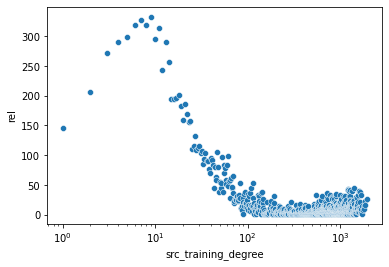

In [69]:
import seaborn as sns
test_triples_prot_as_src = test_triples_by_node_endpoint_to_predict[NODE_ENDPOINT_TO_PREDICT]
prot_degrees = test_triples_prot_as_src.groupby(['src_training_degree'])[COL_EDGE].agg('count').reset_index()
sns.scatterplot(data=prot_degrees, x='src_training_degree', y='rel')
plt.xscale('log')
#plt.yscale('log')

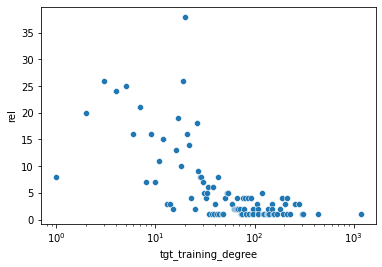

In [70]:
import seaborn as sns
test_triples_prot_as_tgt = test_triples_by_node_endpoint_to_predict[COL_TARGET]
prot_degrees = test_triples_prot_as_tgt.groupby(['tgt_training_degree'])[COL_EDGE].agg('count').reset_index()
sns.scatterplot(data=prot_degrees, x='tgt_training_degree', y='rel')
plt.xscale('log')
#plt.yscale('log')

<AxesSubplot:ylabel='tgt_training_degree'>

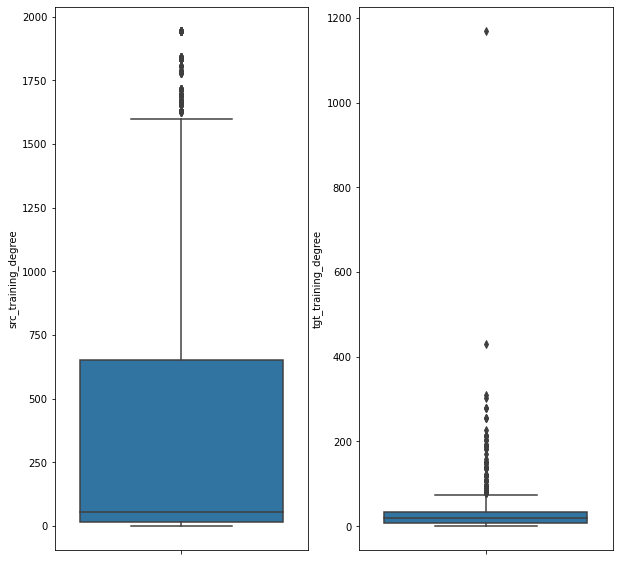

In [71]:
plot, ax = plt.subplots(1, 2, figsize=(10,10))
sns.boxplot(ax=ax[0], y=test_triples_prot_as_src['src_training_degree'])
sns.boxplot(ax=ax[1], y=test_triples_prot_as_tgt['tgt_training_degree'])

In [72]:
from pykeen.triples.triples_factory import TriplesFactory
train_triples=triples_dict.get(TRAIN)
valid_triples=triples_dict[VALID]

#### dummy test data

In [112]:
#test run
print(ENTITY_TYPE_W_ATTR_ENCODE)
dummy_test_inc_attr, _ = create_entity_attr_aware_test_sets(entity_type_w_attribute=ENTITY_TYPE_W_ATTR_ENCODE,
                                                            graph_cfg=graph_cfg,
                                                            train=train,
                                                            test=dummy)
DUMMY_TEST_INCL_ATTR='DUMMY_TEST_INCL_ATTR'
triples_dict.update({DUMMY_TEST_INCL_ATTR: dummy_test_inc_attr})
dummy_test_inc_attr.num_triples


Reconstructing all label-based triples. This is expensive and rarely needed.
Reconstructing all label-based triples. This is expensive and rarely needed.


# drug entities in larger biokg (pre-benchmark removal): 13580
# drug entities for which we have attributes: 10815


36

### evaluate on node degree buckets

In [115]:
MODEL_ID = BIOBLP_D
ENTITY_TYPE_W_ATTR_ENCODE = DISEASE  # is to be controlled when creating test sets
NODE_ENDPOINT_TO_PREDICT = COL_SOURCE
TEST_SET_SLUG = ENT_SPECIFIC_TEST_SET_STUBS[ENTITY_TYPE_W_ATTR_ENCODE]  # DUMMY_TEST_INCL_ATTR
# eval_out_dir = Path(f"./metrics/")

nde = NodeDegreeEvalAnalyser(train_triples, ENT_ASSOC_REL_NAMES)
results_by_node_degree_dicts_bioblpd = nde.evaluate_and_format(entity_type_to_predict=ENTITY_TYPE_W_ATTR_ENCODE,
                                                  node_endpoint_to_predict=COL_SOURCE,
                                                  test_triples=triples_dict[TEST_SET_SLUG], 
                                                  test_set_slug=TEST_SET_SLUG,
                                                  model_id=MODEL_ID,
                                                  train_triples=triples_dict.get(TRAIN),
                                                  valid_triples=triples_dict.get(VALID),
                                                  model_registry_cfg=model_reg_cfg,
                                                  eval_out_dir="./metrics",
                                                  eval_metric_type=EVAL_METRIC_REALISTIC,
                                                  write_results_to_file=True
                                                  )

Reconstructing all label-based triples. This is expensive and rarely needed.
Reconstructing all label-based triples. This is expensive and rarely needed.


Evaluating LP metrics on triples which have disease in src position, using kge from model bioblpd-38uz9fjs-16-03-2023
loaded model from /home/jovyan/workbench-shared-folder/bioblp/models/bioblpd-38uz9fjs-16-03-2023


100%|██████████| 2/2 [00:21<00:00, 10.98s/it]

Writing results to metrics/bioblpd-38uz9fjs-16-03-2023/20230420-083808/node-degree-eval.json
Writing results to metrics/bioblpd-38uz9fjs-16-03-2023/20230420-083808/metadata.json


In [127]:
(0.0007401924231089652+0.003831417532637715)/2

0.0022858049778733402

In [128]:
# sanity check that the mirco averaged eval scores, match what is obtained from thenode degree analysis
from nb_utils.eval_utils import evaluate_lp_all_rels_on_single_test_set, EVAL_NODE_HEAD, EVAL_NODE_TAIL
model = load_kge_model(model_registry_paths[MODEL_ID])
test_triples_rel_restricted = test_triples_incl_ent_prop.new_with_restriction(relations=ENT_ASSOC_REL_NAMES[ENTITY_TYPE_W_ATTR_ENCODE][NODE_ENDPOINT_TO_PREDICT])

microvg_lp_func_kwargs = {"model": model, 
                     "eval_test_set_slug": TEST,
                     "eval_triples": test_triples_rel_restricted,
                     "train_triples": triples_dict.get(TRAIN),
                     "valid_triples": triples_dict.get(VALID)}

microvg_lp_results = evaluate_lp_all_rels_on_single_test_set(eval_triple_node_endpoint=EVAL_NODE_HEAD, **microvg_lp_func_kwargs)


Evaluating on cuda:0: 100%|██████████| 2.00/2.00 [00:00<00:00, 7.23triple/s]


In [129]:
microvg_lp_results

{'Relation': 'All',
 'Count': 2,
 'hits_at_1': 0.0,
 'hits_at_3': 0.0,
 'hits_at_5': 0.0,
 'hits_at_10': 0.0,
 'inverse_harmonic_mean_rank': 0.0022858050651848316}

In [117]:
results_by_node_degree_dicts_bioblpm['head']

{332.0: {'Relation': 'All',
  'Count': 1,
  'hits_at_1': 0.0,
  'hits_at_3': 0.0,
  'hits_at_5': 0.0,
  'hits_at_10': 0.0,
  'inverse_harmonic_mean_rank': 0.0007401924231089652},
 1387.0: {'Relation': 'All',
  'Count': 1,
  'hits_at_1': 0.0,
  'hits_at_3': 0.0,
  'hits_at_5': 0.0,
  'hits_at_10': 0.0,
  'inverse_harmonic_mean_rank': 0.003831417532637715}}

In [55]:
MODEL_ID = BIOBLP_M
ENTITY_TYPE_W_ATTR_ENCODE = DRUG  
NODE_ENDPOINT_TO_PREDICT = COL_SOURCE
TEST_SET_SLUG = ENT_SPECIFIC_TEST_SET_STUBS[ENTITY_TYPE_W_ATTR_ENCODE]

nde = NodeDegreeEvalAnalyser(train_triples, ENT_ASSOC_REL_NAMES)
results_by_node_degree_dicts_bioblpm = nde.evaluate_and_format(entity_type_to_predict=ENTITY_TYPE_W_ATTR_ENCODE,
                                                  node_endpoint_to_predict=COL_SOURCE,
                                                  test_triples=triples_dict[TEST_SET_SLUG], 
                                                  test_set_slug=TEST_SET_SLUG,
                                                  model_id=MODEL_ID,
                                                  train_triples=triples_dict.get(TRAIN),
                                                  valid_triples=triples_dict.get(VALID),
                                                  model_registry_cfg=model_reg_cfg,
                                                  eval_out_dir="./metrics",
                                                  eval_metric_type=EVAL_METRIC_REALISTIC,
                                                  write_results_to_file=True                                                  
)

Reconstructing all label-based triples. This is expensive and rarely needed.
Reconstructing all label-based triples. This is expensive and rarely needed.


loaded model from /home/jovyan/workbench-shared-folder/bioblp/models/bioblpm-5rxz3k57


100%|██████████| 1170/1170 [7:48:53<00:00, 24.05s/it] 


#### predict with rotate - drug

In [60]:
MODEL_ID = ROTATE
ENTITY_TYPE_W_ATTR_ENCODE = DRUG  
NODE_ENDPOINT_TO_PREDICT = COL_SOURCE
TEST_SET_SLUG = ENT_SPECIFIC_TEST_SET_STUBS[ENTITY_TYPE_W_ATTR_ENCODE]

nde = NodeDegreeEvalAnalyser(train_triples, ENT_ASSOC_REL_NAMES)
results_by_node_degree_dicts_bioblpm = nde.evaluate_and_format(entity_type_to_predict=ENTITY_TYPE_W_ATTR_ENCODE,
                                                  node_endpoint_to_predict=COL_SOURCE,
                                                  test_triples=triples_dict[TEST_SET_SLUG], 
                                                  test_set_slug=TEST_SET_SLUG,
                                                  model_id=MODEL_ID,
                                                  train_triples=triples_dict.get(TRAIN),
                                                  valid_triples=triples_dict.get(VALID),
                                                  model_registry_cfg=model_reg_cfg,
                                                  eval_out_dir="./metrics",
                                                  eval_metric_type=EVAL_METRIC_REALISTIC,
                                                  write_results_to_file=True                                                  
)

Reconstructing all label-based triples. This is expensive and rarely needed.
Reconstructing all label-based triples. This is expensive and rarely needed.


loaded model from /home/jovyan/workbench-shared-folder/bioblp/models/rotate-otxtubeb


100%|██████████| 1170/1170 [7:36:25<00:00, 23.41s/it] 


#### predict on protein-containing relations using BioBLP-P and ROTATE

In [ ]:
MODEL_ID = BIOBLP_P
ENTITY_TYPE_W_ATTR_ENCODE = PROTEIN  
NODE_ENDPOINT_TO_PREDICT = COL_SOURCE
TEST_SET_SLUG = ENT_SPECIFIC_TEST_SET_STUBS[ENTITY_TYPE_W_ATTR_ENCODE]

nde = NodeDegreeEvalAnalyser(train_triples, ENT_ASSOC_REL_NAMES)
results_by_node_degree_dicts_bioblpm = nde.evaluate_and_format(entity_type_to_predict=ENTITY_TYPE_W_ATTR_ENCODE,
                                                  node_endpoint_to_predict=COL_SOURCE,
                                                  test_triples=triples_dict[TEST_SET_SLUG], 
                                                  test_set_slug=TEST_SET_SLUG,
                                                  model_id=MODEL_ID,
                                                  train_triples=triples_dict.get(TRAIN),
                                                  valid_triples=triples_dict.get(VALID),
                                                  model_registry_cfg=model_reg_cfg,
                                                  eval_out_dir="./metrics",
                                                  eval_metric_type=EVAL_METRIC_REALISTIC,
                                                  write_results_to_file=True                                                  
)

In [ ]:
MODEL_ID = ROTATE
ENTITY_TYPE_W_ATTR_ENCODE = PROTEIN  
NODE_ENDPOINT_TO_PREDICT = COL_SOURCE
TEST_SET_SLUG = ENT_SPECIFIC_TEST_SET_STUBS[ENTITY_TYPE_W_ATTR_ENCODE]

eval_out_dir = Path(f"./metrics/{MODEL_ID}")
nde = NodeDegreeEvalAnalyser(train_triples, ENT_ASSOC_REL_NAMES)
results_by_node_degree_dicts_bioblpm = nde.evaluate_and_format(entity_type_to_predict=ENTITY_TYPE_W_ATTR_ENCODE,
                                                  node_endpoint_to_predict=COL_SOURCE,
                                                  test_triples=test, 
                                                  test_set_slug=TEST_RESTRICTED_ENT,
                                                  model_id=MODEL_ID,
                                                  train_triples=triples_dict.get(TRAIN),
                                                  valid_triples=triples_dict.get(VALID),
                                                  model_registry_cfg=model_reg_cfg,
                                                  eval_out_dir="./metrics",
                                                  eval_metric_type=EVAL_METRIC_REALISTIC,
                                                  write_results_to_file=True
                                                  )esults_by_node_degree_dicts_rotate = x.format_eval_results(results_dict, eval_triple_endpoint=EVAL_NODE_HEAD, eval_metric_type=EVAL_METRIC_REALISTIC)


Reconstructing all label-based triples. This is expensive and rarely needed.
Reconstructing all label-based triples. This is expensive and rarely needed.


loaded model from /home/jovyan/workbench-shared-folder/bioblp/models/rotate-otxtubeb


 52%|█████▏    | 133/256 [47:55<27:57, 13.64s/it] 

### Plots V2 - (improved 17/03) - Plotting the difference in LP scores by RotatE and BioBLP-X

In [72]:
MODEL_ID = ROTATE
eval_out_dir = Path(f"./metrics/{MODEL_ID}/20230417-164617")
with open(eval_out_dir.joinpath('node-degree-eval.json'), 'r') as f:
    results_by_node_degree_dicts_rotate_drug = json.load(f)

    
MODEL_ID = BIOBLP_M
eval_out_dir = Path(f"./metrics/{MODEL_ID}/20230417-074027")
#eval_out_dir = Path(f"/metrics/{MODEL_ID}")
with open(eval_out_dir.joinpath('node-degree-eval.json'), 'r') as f:
    results_by_node_degree_dicts_bioblpm = json.load(f)


In [73]:
rotate_df = pd.DataFrame.from_dict(results_by_node_degree_dicts_rotate_drug, orient='index')
rotate_df = rotate_df.reset_index().rename(columns={'index':'degree'})
rotate_df = rotate_df.astype({'degree':'float'})

bioblpm_df = pd.DataFrame.from_dict(results_by_node_degree_dicts_bioblpm, orient='index')
bioblpm_df = bioblpm_df.reset_index().rename(columns={'index':'degree'})
bioblpm_df = bioblpm_df.astype({'degree':'float'})


In [78]:
def compare_and_plot(rotate_df, bioblp_df, 
                     test_triples_subset=tes, 
                     node_endpoint_type=NODE_ENDPOINT_TO_PREDICT):
    merged_df = rotate_df.merge(bioblp_df, how='inner', on='degree', suffixes=['_rotate', '_bioblp'])
    merged_df.drop(columns=['Relation_bioblp', 'Relation_rotate', 'Count_bioblp'], inplace=True)
    merged_df = merged_df.astype({'degree':'float'})
    merged_df = merged_df.rename(columns={"Count_rotate":"count"})
    
    merged_df['num_unique_ents'] = merged_df['degree'].apply(
    lambda x: len(get_unique_endpoint_entities_in_testset_of_given_degree(test_triples_subset, 
                                                                          degree=x, 
                                                                          node_endpoint_type=node_endpoint_type)))
    return merged_df
merged_df_bioblpm_rotate = compare_and_plot(rotate_df, bioblpm_df)
merged_df_bioblpm_rotate[:3]

,degree,count,hits_at_1_rotate,hits_at_3_rotate,hits_at_5_rotate,hits_at_10_rotate,inverse_harmonic_mean_rank_rotate,hits_at_1_bioblp,hits_at_3_bioblp,hits_at_5_bioblp,hits_at_10_bioblp,inverse_harmonic_mean_rank_bioblp,num_unique_ents
0,429.0,80,0.062500,0.150000,0.187500,0.375000,0.147620,0.025000,0.062500,0.087500,0.137500,0.065420,79
1,269.0,27,0.000000,0.074074,0.148148,0.296296,0.084560,0.037037,0.148148,0.148148,0.185185,0.111043,27
2,733.0,92,0.097826,0.271739,0.347826,0.500000,0.219906,0.000000,0.021739,0.032609,0.043478,0.025285,92


In [79]:
from nb_utils.eval_utils import EVAL_METRICS_SHORTLIST
for metric in EVAL_METRICS_SHORTLIST:
    merged_df_bioblpm_rotate[metric] = merged_df_bioblpm_rotate[f'{metric}_rotate'] - merged_df_bioblpm_rotate[f'{metric}_bioblp']

In [56]:
rotate_df = pd.DataFrame.from_dict(results_by_node_degree_dicts_rotate, orient='index')
rotate_df = rotate_df.reset_index().rename(columns={'index':'degree'})
rotate_df = rotate_df.astype({'degree':'float'})

bioblpp_df = pd.DataFrame.from_dict(results_by_node_degree_dicts_bioblpp, orient='index')
bioblpp_df = bioblpp_df.reset_index().rename(columns={'index':'degree'})
bioblpp_df = bioblpp_df.astype({'degree':'float'})


In [80]:
merged_df = merged_df_bioblpm_rotate
min_c, max_c, mean_c, std_c = merged_df['count'].min(), merged_df['count'].max(), merged_df['count'].mean(), merged_df['count'].std()
merged_df['proportion'] = (merged_df['count']-min_c)/(max_c-min_c)
merged_df.proportion.describe()

count    1170.000000
mean        0.192058
std         0.172886
min         0.000000
25%         0.056881
50%         0.141284
75%         0.278899
max         1.000000
Name: proportion, dtype: float64

In [81]:
merged_df[merged_df['degree']==1.0]

,degree,count,hits_at_1_rotate,hits_at_3_rotate,hits_at_5_rotate,hits_at_10_rotate,inverse_harmonic_mean_rank_rotate,hits_at_1_bioblp,hits_at_3_bioblp,hits_at_5_bioblp,hits_at_10_bioblp,inverse_harmonic_mean_rank_bioblp,num_unique_ents,hits_at_1,hits_at_3,hits_at_5,hits_at_10,inverse_harmonic_mean_rank,proportion
840,1.0,299,0.772575,0.892977,0.93311,0.939799,0.839699,0.006689,0.020067,0.020067,0.0301,0.018144,194,0.765886,0.87291,0.913043,0.909699,0.821555,0.546789


In [61]:
from nb_utils.eval_utils import EVAL_METRICS_SHORTLIST
for metric in EVAL_METRICS_SHORTLIST:
    merged_df[metric] = merged_df[f'{metric}_rotate'] - merged_df[f'{metric}_bioblpp']

### define plotting logic

In [73]:
from nb_utils.plot_utils import plot_metric_vs_degree_scatterplot_multi_models
from nb_utils.plot_utils import plot_metric_vs_degree_scatterplot_single_model


In [ ]:
import matplotlib.ticker as ticker
metric_name=IN_DEGREEnverse_harmonic_mean_rank'
degrees, metrics, counts, props, num_unique_ents = merged_df['degree'], merged_df[metric_name], merged_df['count'] , merged_df['proportion'], merged_df['num_unique_ents']
plot, ax = plt.subplots(figsize=(10,10))
sns.color_palette("flare", as_cmap=True)
#s_square = [n*n for n in props] 
s_square = [n*n for n in num_unique_ents] 
plot_ = sns.scatterplot(ax = ax, x=degrees, y=metrics, size=num_unique_ents, sizes=(10,200))
plt.xscale('log')
#ax.legend(title='# unique entities')
plt.ylabel(metric_name)
plt.xlabel(f'Training degree for {ENTITY_TYPE_W_ATTR_ENCODE} entity being predicted')
plt.xticks(degrees, rotation='vertical')

plot_.xaxis.set_major_locator(ticker.IndexLocator(100, 0))

plt.title(f'(avg_{metric_name}_rotate) - (avg_{metric_name}_{BIOBLP_M}) \n Difference b/w both models in {metric_name} when predicting {ENTITY_TYPE_W_ATTR_ENCODE} as {NODE_ENDPOINT_TO_PREDICT} node, Vs. {ENTITY_TYPE_W_ATTR_ENCODE} node degree')
plt.savefig(f'data/imgs/{metric_name}_node_degree_analysis-{BIOBLP_M}-{ROTATE}')

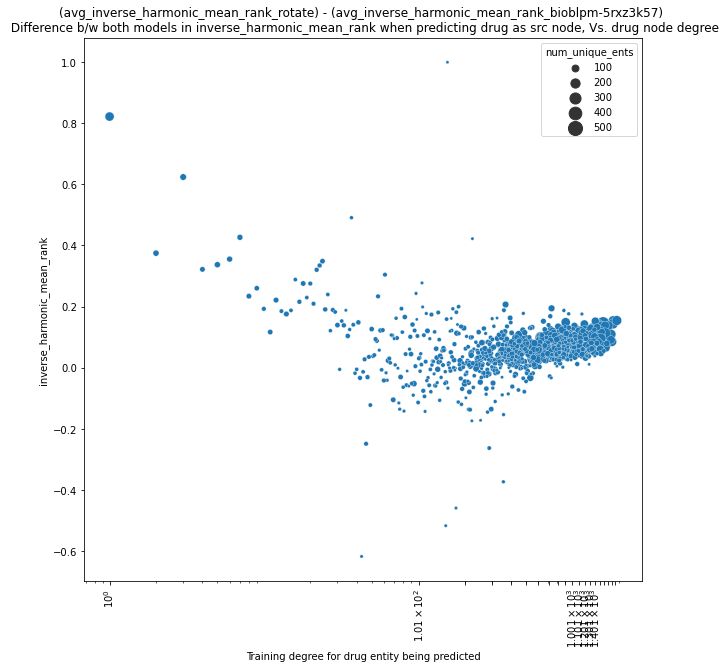

In [86]:
import matplotlib.ticker as ticker
metric_name='inverse_harmonic_mean_rank'
#metric_name='hits_at_10'
degrees, metrics, counts, props, num_unique_ents = merged_df['degree'], merged_df[metric_name], merged_df['count'] , merged_df['proportion'], merged_df['num_unique_ents']
plot, ax = plt.subplots(figsize=(10,10))
sns.color_palette("flare", as_cmap=True)
#s_square = [n*n for n in props] 
s_square = [n*n for n in num_unique_ents] 
plot_ = sns.scatterplot(ax = ax, x=degrees, y=metrics, size=num_unique_ents, sizes=(10,200))
plt.xscale('log')
#ax.legend(title='# unique entities')
plt.ylabel(metric_name)
plt.xlabel(f'Training degree for {ENTITY_TYPE_W_ATTR_ENCODE} entity being predicted')
plt.xticks(degrees, rotation='vertical')

plot_.xaxis.set_major_locator(ticker.IndexLocator(100, 0))

plt.title(f'(avg_{metric_name}_rotate) - (avg_{metric_name}_{BIOBLP_M}) \n Difference b/w both models in {metric_name} when predicting {ENTITY_TYPE_W_ATTR_ENCODE} as {NODE_ENDPOINT_TO_PREDICT} node, Vs. {ENTITY_TYPE_W_ATTR_ENCODE} node degree')
plt.savefig(f'data/imgs/{metric_name}_node_degree_analysis-{BIOBLP_M}-{ROTATE}')

NameError: name 'cmap' is not defined

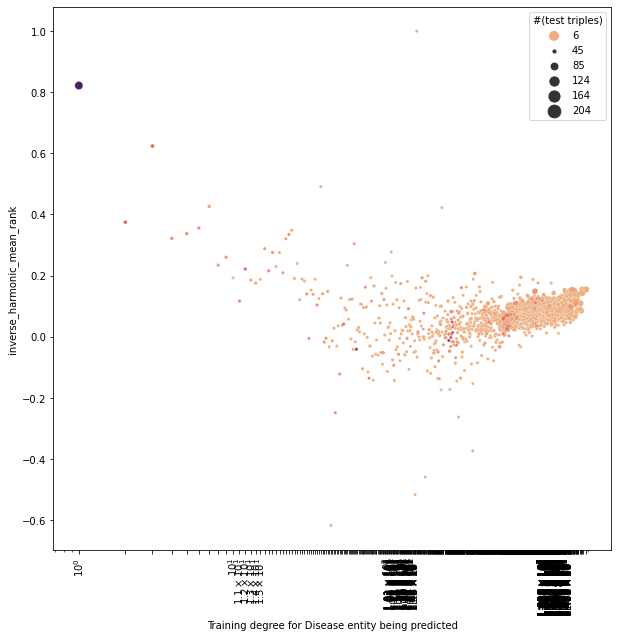

In [98]:
import matplotlib.ticker as ticker
metric_name='inverse_harmonic_mean_rank'
#metric_name='hits_at_10'
degrees, metrics, counts, props, num_unique_ents = merged_df['degree'], merged_df[metric_name], merged_df['count'] , merged_df['proportion'], merged_df['count']/merged_df['num_unique_ents']
plot, ax = plt.subplots(figsize=(10,10))
sns.color_palette("flare", as_cmap=True)
s_linear = [n*n for n in props] 
plot_ = sns.scatterplot(ax = ax, x=degrees, y=metrics, size=s_linear, sizes=(10,200), c=num_unique_ents, cmap='flare')
plt.xscale('log')
ax.legend(title='#(test triples)', labels = ['6', '45', '85', '124', '164', '204'])
plt.ylabel(metric_name)
plt.xlabel('Training degree for Disease entity being predicted')
plt.xticks(degrees, rotation='vertical')
#plot_.legend(loc='upper right', bbox_to_anchor=(1.2, 1.0), ncol=1)

norm = plt.Normalize(num_unique_ents.min(), num_unique_ents.max())
cbar = ax.figure.colorbar(plt.cm.ScalarMappable(norm=norm,
                                                cmap=cmap),
                          #ticks=np.arange(num_unique_ents.min(), num_unique_ents.max() + 1),
                          label=f'# test_triples per unique {ENTITY_TYPE_W_ATTR_ENCODE}')

plot_.xaxis.set_major_locator(ticker.IndexLocator(100, 0))

plt.title(f'avg_{metric_name}_rotate - avg_{metric_name}_bioblpm \n Difference in {metric_name} (averaged over test triples with {ENTITY_TYPE_W_ATTR_ENCODE} node of certain node (training) degree) b/w both models, Vs. {ENTITY_TYPE_W_ATTR_ENCODE} node degree')
plt.savefig(f'data/imgs/{metric_name}_node_degree_analysis')

In [94]:
import matplotlib.pyplot as plt
from nb_utils.plot_utils import plot_metric_vs_degree_scatterplot_single_model
from nb_utils.plot_utils import plot_metric_vs_degree_scatterplot_multi_models

img_outdir = Path('./data/imgs/')


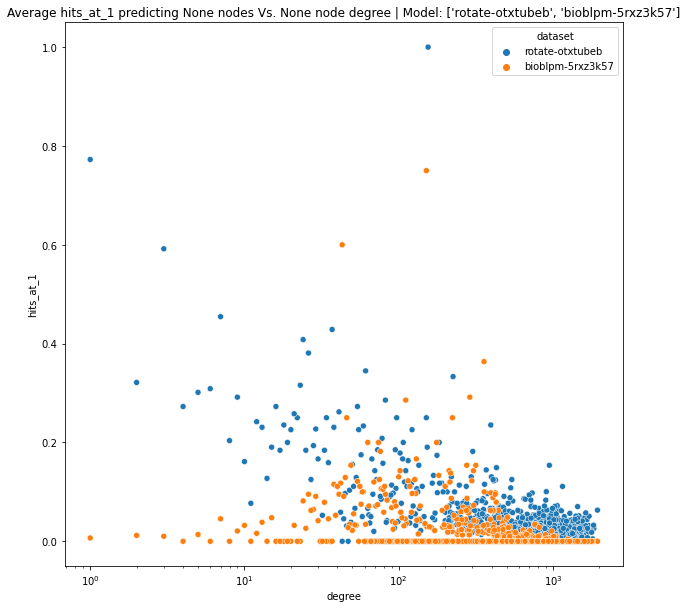

In [95]:
EVAL_OUT_DIR_NODE_DEGREE_ANALYSIS = "./data/imgs/node-degree-analysis-rotate-and-bioblpm"
model_result_dicts = {ROTATE: results_by_node_degree_dicts_rotate_drug,
                     BIOBLP_M: results_by_node_degree_dicts_bioblpm}#results_by_node_degree_dicts_bioblp}
x = plot_metric_vs_degree_scatterplot_multi_models(metric_name='hits_at_1', results_by_node_degree_dicts_combined=model_result_dicts,
                                                  eval_out_dir=EVAL_OUT_DIR_NODE_DEGREE_ANALYSIS)


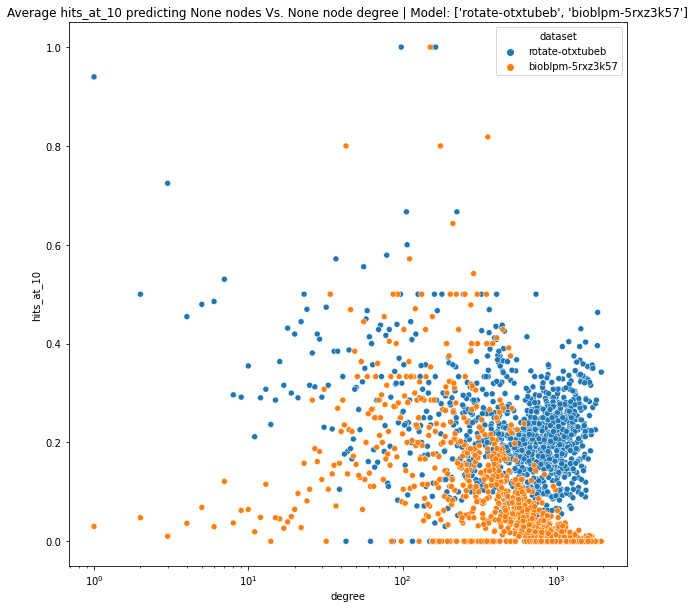

In [96]:
x = plot_metric_vs_degree_scatterplot_multi_models(metric_name='hits_at_10', results_by_node_degree_dicts_combined=model_result_dicts,
                                                  eval_out_dir=EVAL_OUT_DIR_NODE_DEGREE_ANALYSIS)


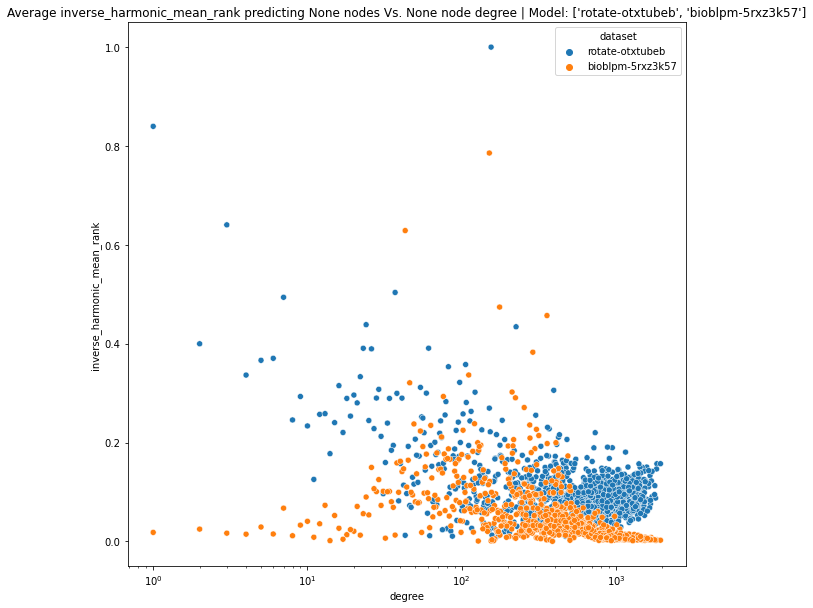

In [97]:
x = plot_metric_vs_degree_scatterplot_multi_models(metric_name='inverse_harmonic_mean_rank', results_by_node_degree_dicts_combined=model_result_dicts,
                                                  eval_out_dir=EVAL_OUT_DIR_NODE_DEGREE_ANALYSIS)


In [98]:
wandb.login()

True

In [99]:
tags = {"model_name": BIOBLP_M),
        "study_name": 'node_degree_trends_both_models_combined',
        "test_set_type": TEST_RESTRICTED_ENT}
run = setup_wandb_result_tracker(**tags, 
                                 notes=f'combined lp results for {BIOBLP_M)} and {MODELS.get(ROTATE)}', 
                                 project_name='bioblp-jupyter-trial',
                                 wandb_entity='discoverylab')

Save custom plots to Weights and biases

In [117]:
!ls {EVAL_OUT_DIR_NODE_DEGREE_ANALYSIS}

20230324-173105-hits_at_1_node_degree_analysis-rotate-otxtubeb-20230324-173105.png
20230324-173137-hits_at_10_node_degree_analysis-rotate-otxtubeb-20230324-173137.png
20230324-173248-inverse_harmonic_mean_rank_node_degree_analysis-rotate-otxtubeb-20230324-173248.png
20230324-173341-hits_at_1_node_degree_analysis-bioblpp-cttc3ucm-20230324-173341.png
20230324-173404-hits_at_10_node_degree_analysis-bioblpp-cttc3ucm-20230324-173404.png
20230324-173426-inverse_harmonic_mean_rank_node_degree_analysis-bioblpp-cttc3ucm-20230324-173426.png
20230324-174518-inverse_harmonic_mean_rank_node_degree_analysis-rotate-otxtubeb-bioblpp-cttc3ucm.png
20230324-174536-hits_at_10_node_degree_analysis-rotate-otxtubeb-bioblpp-cttc3ucm.png
20230324-174539-hits_at_1_node_degree_analysis-rotate-otxtubeb-bioblpp-cttc3ucm.png


In [120]:
#degree_analysis_hits_at_1_rotate_and_bioblpp_path = f"{EVAL_OUT_DIR_NODE_DEGREE_ANALYSIS}/20230324-174539-hits_at_1_node_degree_analysis-rotate-otxtubeb-bioblpp-cttc3ucm.png"
#degree_analysis_hits_at_10_rotate_and_bioblpp_path = f"{EVAL_OUT_DIR_NODE_DEGREE_ANALYSIS}/20230324-174536-hits_at_10_node_degree_analysis-rotate-otxtubeb-bioblpp-cttc3ucm.png"
degree_analysis_mrr_rotate_and_bioblpp_path = f"{EVAL_OUT_DIR_NODE_DEGREE_ANALYSIS}/20230324-174518-inverse_harmonic_mean_rank_node_degree_analysis-rotate-otxtubeb-bioblpp-cttc3ucm.png"

wandb.log({"hits@1_combined_bioblpm_rotate": wandb.Image(degree_analysis_hits_at_1_rotate_and_bioblpm_path)})
wandb.log({"hits@10_combined_bioblpm_rotate": wandb.Image(degree_analysis_hits_at_10_rotate_and_bioblpm_path)})
wandb.log({"mrr_combined_bioblpm_rotate": wandb.Image(degree_analysis_mrr_rotate_and_bioblpm_path)})

In [ ]:
todo - change for bioblpp -> add the new diff plots!
todo - compare micro averages to sanity check

In [187]:
#degree_analysis_hits_at_10_bioblpd_path = "./data/imgs/node_analysis_hits_at_10_bioblpd.png"
#degree_analysis_hits_at_1_bioblpd_path = "./data/imgs/node_analysis_hits_at_1_bioblpd.png"

#wandb.log({"hits@10_bioblpd": wandb.Image(degree_analysis_hits_at_10_bioblpd_path)})
#wandb.log({"hits@1_bioblpd": wandb.Image(degree_analysis_hits_at_1_bioblpd_path)})

### Protein stuff

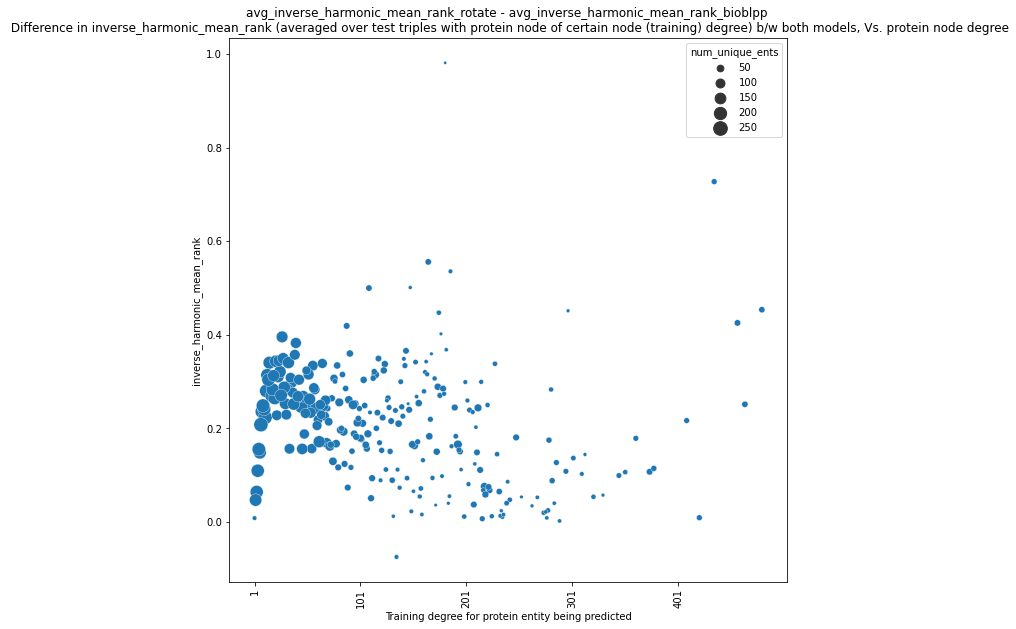

In [58]:
import matplotlib.ticker as ticker
metric_name='inverse_harmonic_mean_rank'
#metric_name='hits_at_1'
degrees, metrics, counts, props, num_unique_ents = merged_df['degree'], merged_df[metric_name], merged_df['count'] , merged_df['proportion'], merged_df['num_unique_ents']
plot, ax = plt.subplots(figsize=(10,10))
sns.color_palette("flare", as_cmap=True)
#s_square = [n*n for n in props] 
s_square = [n*n for n in num_unique_ents] 
plot_ = sns.scatterplot(ax = ax, x=degrees, y=metrics, size=num_unique_ents, sizes=(10,200))
#plt.xscale('log')
#ax.legend(title='# unique entities')
plt.ylabel(metric_name)
plt.xlabel(f'Training degree for {ENTITY_TYPE_W_ATTRIBUTE} entity being predicted')
plt.xticks(degrees, rotation='vertical')

plot_.xaxis.set_major_locator(ticker.IndexLocator(100, 0))

plt.title(f'avg_{metric_name}_rotate - avg_{metric_name}_bioblpp \n Difference in {metric_name} (averaged over test triples with {ENTITY_TYPE_W_ATTRIBUTE} node of certain node (training) degree) b/w both models, Vs. {ENTITY_TYPE_W_ATTRIBUTE} node degree')
plt.savefig(f'data/imgs/{metric_name}_node_degree_analysis')

NameError: name 'cmap' is not defined

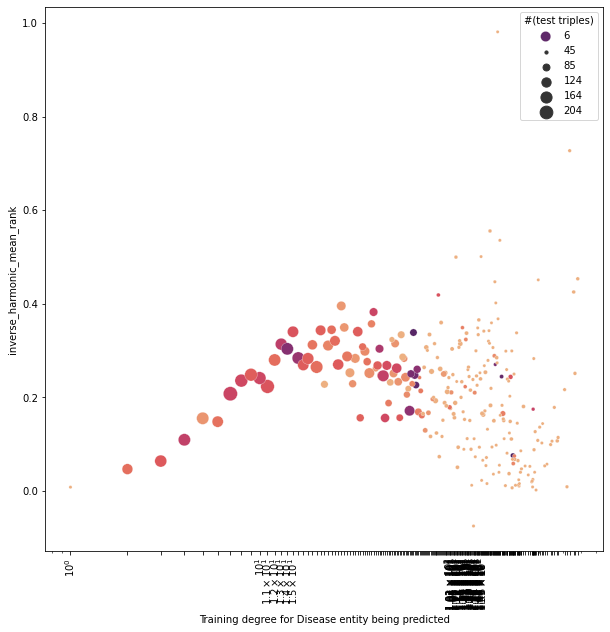

In [87]:
import matplotlib.ticker as ticker
metric_name='inverse_harmonic_mean_rank'
#metric_name='hits_at_10'
degrees, metrics, counts, props, num_unique_ents = merged_df['degree'], merged_df[metric_name], merged_df['count'] , merged_df['proportion'], merged_df['count']/merged_df['num_unique_ents']
plot, ax = plt.subplots(figsize=(10,10))
sns.color_palette("flare", as_cmap=True)
s_linear = [n*n for n in props] 
plot_ = sns.scatterplot(ax = ax, x=degrees, y=metrics, size=s_linear, sizes=(10,200), c=num_unique_ents, cmap='flare')
plt.xscale('log')
ax.legend(title='#(test triples)', labels = ['6', '45', '85', '124', '164', '204'])
plt.ylabel(metric_name)
plt.xlabel('Training degree for Disease entity being predicted')
plt.xticks(degrees, rotation='vertical')
#plot_.legend(loc='upper right', bbox_to_anchor=(1.2, 1.0), ncol=1)

norm = plt.Normalize(num_unique_ents.min(), num_unique_ents.max())
cbar = ax.figure.colorbar(plt.cm.ScalarMappable(norm=norm,
                                                cmap=cmap),
                          #ticks=np.arange(num_unique_ents.min(), num_unique_ents.max() + 1),
                          label=r'# test_triples per unique disease')

plot_.xaxis.set_major_locator(ticker.IndexLocator(100, 0))

plt.title(f'avg_{metric_name}_rotate - avg_{metric_name}_bioblpp \n Difference in {metric_name} (averaged over test triples with {ENTITY_TYPE_W_ATTRIBUTE} node of certain node (training) degree) b/w both models, Vs. disease node degree')
plt.savefig(f'data/imgs/{metric_name}_node_degree_analysis')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


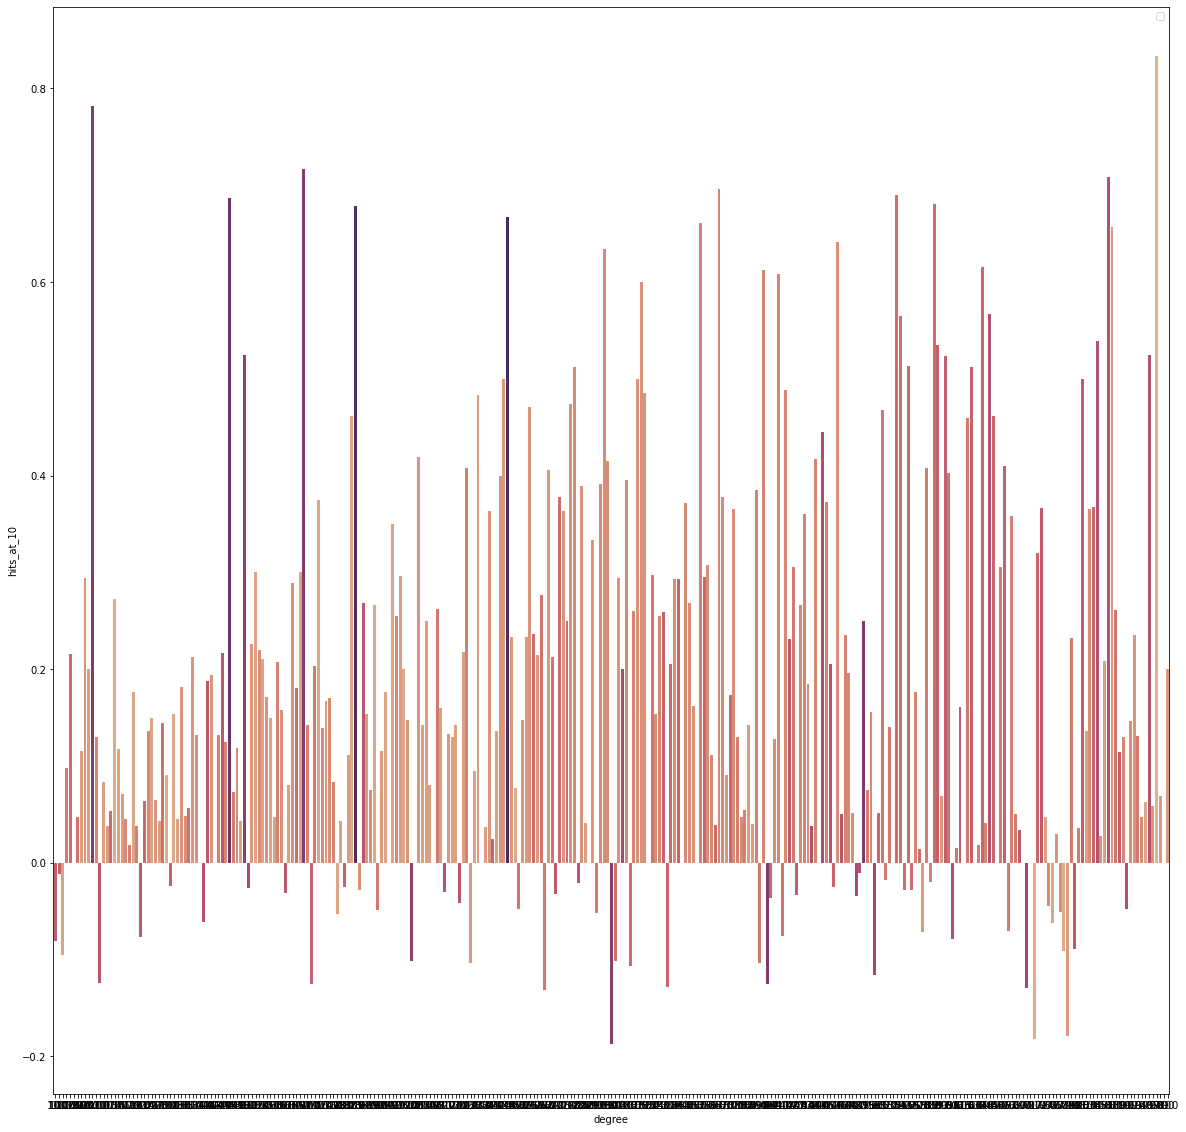

In [187]:
def colors_from_values(values, palette_name):
    # normalize the values to range [0, 1]
    normalized = (values - min(values)) / (max(values) - min(values))
    # convert to indices
    indices = np.round(normalized * (len(values) - 1)).astype(np.int32)
    # use the indices to get the colors
    palette = sns.color_palette(palette_name, len(values))
    return np.array(palette).take(indices, axis=0)
plot, ax = plt.subplots(figsize=(20,20))
sns.barplot(ax=ax, x=degrees, y=metrics, palette=colors_from_values(props, "flare"))
plt.legend()

### Plots V1 - Separate series plotted for BioBLP-D and RotatE

load from file

In [68]:
ENTITY_TYPE_W_ATTRIBUTE = 'Protein'
MODEL_NAME_SLUG = BIOBLP_D
MODEL_ID = MODELS.get(MODEL_NAME_SLUG)  
eval_out_dir = Path(f"./metrics/{MODEL_ID}")
LOAD_FROM_FILE=False
if LOAD_FROM_FILE:
    with open(eval_out_dir.joinpath('node-degree-eval-new.json'), 'r') as f:
        results_by_node_degree_dicts_bioblpd = json.load(f)


In [69]:
plot_metric_vs_degree_scatterplot_single_model(metric_name='hits_at_1',
                                               model_id=MODELS.get(ROTATE),
                                               results_by_node_degree_dict=results_by_node_degree_dicts_rotate,
                                               entity_type_examined=ENTITY_TYPE_W_ATTRIBUTE
                                              )

TypeError: strftime() takes at least 1 argument (0 given)

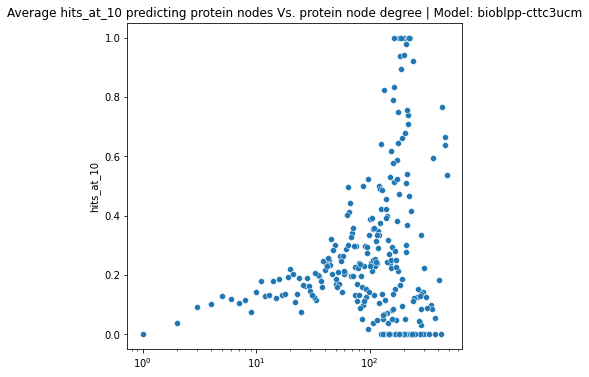

In [91]:
plot_metric_vs_degree_scatterplot_single_model(metric_name='hits_at_10', 
                                               model_id=MODELS.get(BIOBLP_P),
                                               results_by_node_degree_dict=results_by_node_degree_dicts_bioblpp,
                                               entity_type_examined=ENTITY_TYPE_W_ATTRIBUTE,
                                              figsize=(6,6))

In [48]:
tags = {"model_name": MODEL_ID_bioblpp,
        "study_name": 'node_degree_trend',
        "test_set_type": TEST_RESTRICTED_DIS}
run = setup_wandb_result_tracker(**tags, project_name='bioblp-jupyter-trial', wandb_entity='discoverylab')

In [49]:
metric_name = "hits_at_1"
degrees, metrics = extract_relevant_metrics(metric_name, results_by_node_degree_dicts_bioblpdx)
data = [[x, y] for (x, y) in zip(degrees, metrics)]
table = wandb.Table(data=data, columns = ["degrees", "metrics"])
wandb.log({f"bioblpd-{metric_name}_node_degree" : wandb.plot.scatter(table, "degrees", "metrics")})


#### RotatE

All plots below look quite similar!

load from file

In [22]:
MODEL_NAME_SLUG = ROTATE
MODEL_ID = MODELS.get(MODEL_NAME_SLUG)  
eval_out_dir = Path(f"./metrics/{MODEL_ID}")

with open(eval_out_dir.joinpath('node-degree-eval-new.json'), 'r') as f:
    results_by_node_degree_dicts_rotate = json.load(f)


In [92]:
from nb_utils.eval_utils import plot_metric_vs_degree_scatterplot_single_model
from nb_utils.eval_utils import plot_metric_vs_degree_scatterplot_multi_models


ImportError: cannot import name 'plot_metric_vs_degree_scatterplot_single_model' from 'nb_utils.eval_utils' (/home/jovyan/BioBLP/notebooks/nb_utils/eval_utils.py)

In [86]:
EVAL_OUT_DIR_NODE_DEGREE_ANALYSIS = "./data/imgs/node-degree-analysis-rotate-and-bioblpp"

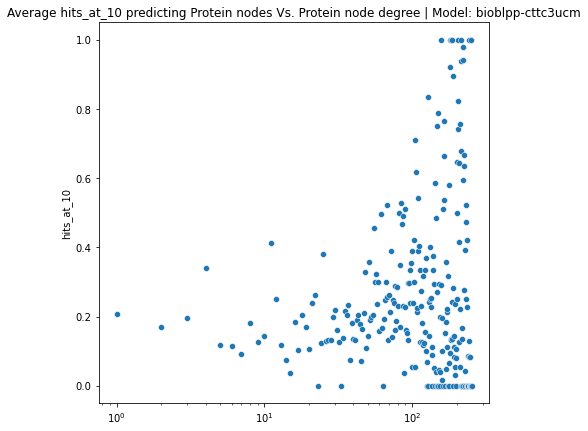

In [92]:
metric_name='hits_at_10'
MODEL_ID = BIOBLP_P
plot_metric_vs_degree_scatterplot_single_model(metric_name=metric_name, 
                                               model_id=MODEL_ID,
                                               eval_out_dir=EVAL_OUT_DIR_NODE_DEGREE_ANALYSIS,
                                               results_by_node_degree_dict=results_by_node_degree_dicts_bioblpp,
                                               entity_type_examined=ENTITY_TYPE_W_ATTR_ENCODE)
#plt.savefig(f'data/imgs/{MODEL_ID}-{metric_name}-{ENTITY_TYPE_W_ATTRIBUTE}_node_degree_analysis')

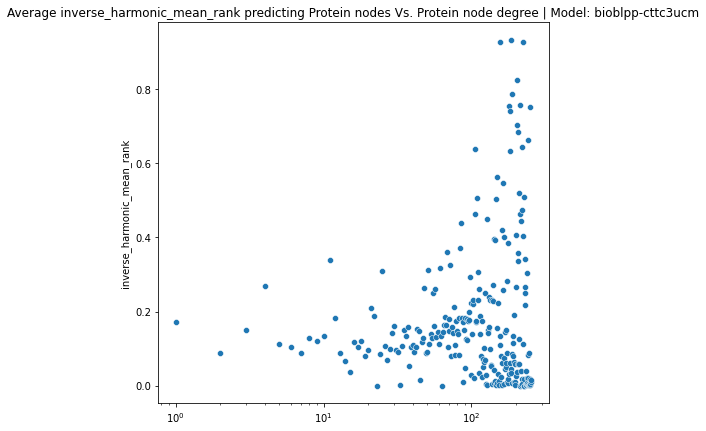

In [93]:
from nb_utils.eval_utils import INVERSE_HARMONIC_MEAN_RANK
MODEL_ID = BIOBLP_P
metric_name=INVERSE_HARMONIC_MEAN_RANK
plot_metric_vs_degree_scatterplot_single_model(metric_name=metric_name, 
                                               model_id=MODEL_IF,
                                               results_by_node_degree_dict=results_by_node_degree_dicts_bioblpp,
                                               entity_type_examined=ENTITY_TYPE_W_ATTR_ENCODE,
                                               eval_out_dir=EVAL_OUT_DIR_NODE_DEGREE_ANALYSIS,
                                              )


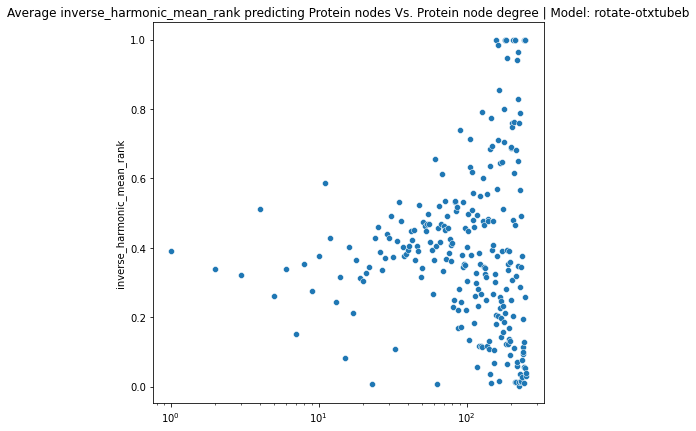

In [90]:
from nb_utils.eval_utils import INVERSE_HARMONIC_MEAN_RANK
MODEL_ID_SLUG = ROTATE
metric_name=INVERSE_HARMONIC_MEAN_RANK
plot_metric_vs_degree_scatterplot_single_model(metric_name=metric_name, 
                                               model_id=MODELS.get(MODEL_ID_SLUG),
                                               results_by_node_degree_dict=results_by_node_degree_dicts_rotate,
                                               entity_type_examined=ENTITY_TYPE_W_ATTRIBUTE,
                                               eval_out_dir=EVAL_OUT_DIR_NODE_DEGREE_ANALYSIS,
                                              )


### combine into one graph

In [53]:
import matplotlib.pyplot as plt
img_outdir = Path('./data/imgs/')


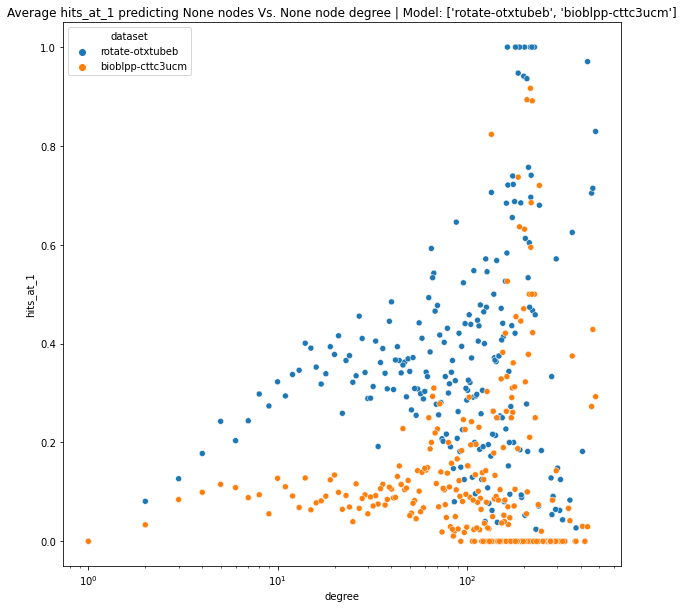

In [114]:
model_result_dicts = {MODEL_ID_rotate: results_by_node_degree_dicts_rotate,
                     MODEL_ID_bioblpp: results_by_node_degree_dicts_bioblpp}#results_by_node_degree_dicts_bioblp}
x = plot_metric_vs_degree_scatterplot_multi_models(metric_name='hits_at_1', results_by_node_degree_dicts_combined=model_result_dicts,
                                                  eval_out_dir=EVAL_OUT_DIR_NODE_DEGREE_ANALYSIS)


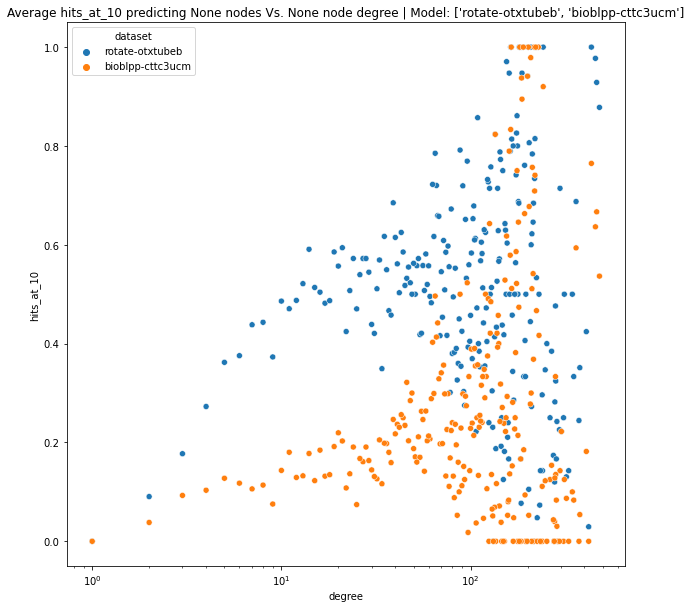

In [113]:
x = plot_metric_vs_degree_scatterplot_multi_models(metric_name='hits_at_10', results_by_node_degree_dicts_combined=model_result_dicts,
                                                  eval_out_dir=EVAL_OUT_DIR_NODE_DEGREE_ANALYSIS)


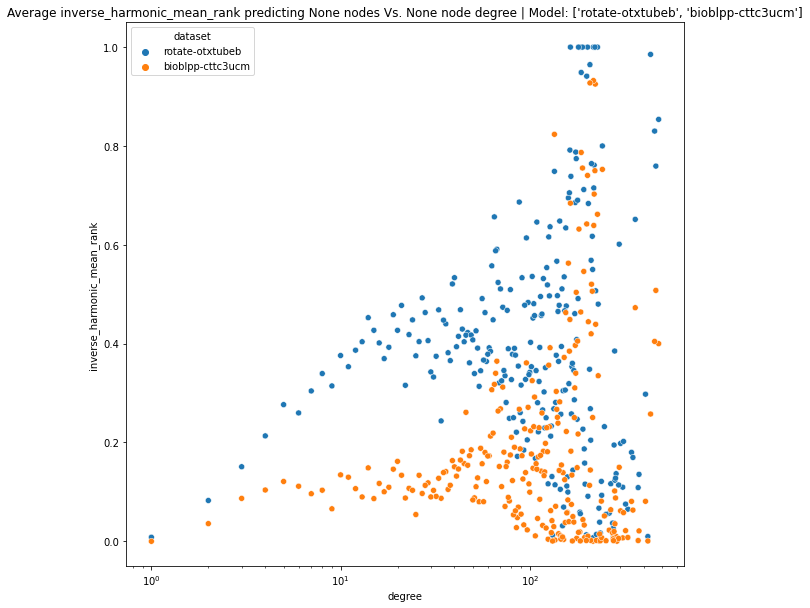

In [112]:
x = plot_metric_vs_degree_scatterplot_multi_models(metric_name='inverse_harmonic_mean_rank', results_by_node_degree_dicts_combined=model_result_dicts,
                                                  eval_out_dir=EVAL_OUT_DIR_NODE_DEGREE_ANALYSIS)


In [98]:
wandb.login()

True

In [99]:
tags = {"model_name": MODELS.get(BIOBLP_P),
        "study_name": 'node_degree_trends_both_models_combined',
        "test_set_type": TEST_RESTRICTED_PROT}
run = setup_wandb_result_tracker(**tags, 
                                 notes=f'combined lp results for {MODELS.get(BIOBLP_P)} and {MODELS.get(ROTATE)}', 
                                 project_name='bioblp-jupyter-trial',
                                 wandb_entity='discoverylab')

Save custom plots to Weights and biases

In [117]:
!ls {EVAL_OUT_DIR_NODE_DEGREE_ANALYSIS}

20230324-173105-hits_at_1_node_degree_analysis-rotate-otxtubeb-20230324-173105.png
20230324-173137-hits_at_10_node_degree_analysis-rotate-otxtubeb-20230324-173137.png
20230324-173248-inverse_harmonic_mean_rank_node_degree_analysis-rotate-otxtubeb-20230324-173248.png
20230324-173341-hits_at_1_node_degree_analysis-bioblpp-cttc3ucm-20230324-173341.png
20230324-173404-hits_at_10_node_degree_analysis-bioblpp-cttc3ucm-20230324-173404.png
20230324-173426-inverse_harmonic_mean_rank_node_degree_analysis-bioblpp-cttc3ucm-20230324-173426.png
20230324-174518-inverse_harmonic_mean_rank_node_degree_analysis-rotate-otxtubeb-bioblpp-cttc3ucm.png
20230324-174536-hits_at_10_node_degree_analysis-rotate-otxtubeb-bioblpp-cttc3ucm.png
20230324-174539-hits_at_1_node_degree_analysis-rotate-otxtubeb-bioblpp-cttc3ucm.png


In [120]:
#degree_analysis_hits_at_1_rotate_and_bioblpp_path = f"{EVAL_OUT_DIR_NODE_DEGREE_ANALYSIS}/20230324-174539-hits_at_1_node_degree_analysis-rotate-otxtubeb-bioblpp-cttc3ucm.png"
#degree_analysis_hits_at_10_rotate_and_bioblpp_path = f"{EVAL_OUT_DIR_NODE_DEGREE_ANALYSIS}/20230324-174536-hits_at_10_node_degree_analysis-rotate-otxtubeb-bioblpp-cttc3ucm.png"
degree_analysis_mrr_rotate_and_bioblpp_path = f"{EVAL_OUT_DIR_NODE_DEGREE_ANALYSIS}/20230324-174518-inverse_harmonic_mean_rank_node_degree_analysis-rotate-otxtubeb-bioblpp-cttc3ucm.png"

wandb.log({"hits@1_combined_bioblpd_rotate": wandb.Image(degree_analysis_hits_at_1_rotate_and_bioblpp_path)})
wandb.log({"hits@10_combined_bioblpd_rotate": wandb.Image(degree_analysis_hits_at_10_rotate_and_bioblpp_path)})
wandb.log({"mrr_combined_bioblpd_rotate": wandb.Image(degree_analysis_mrr_rotate_and_bioblpp_path)})

In [ ]:
todo - change for bioblpp -> add the new diff plots!
todo - compare micro averages to sanity check

In [187]:
#degree_analysis_hits_at_10_bioblpd_path = "./data/imgs/node_analysis_hits_at_10_bioblpd.png"
#degree_analysis_hits_at_1_bioblpd_path = "./data/imgs/node_analysis_hits_at_1_bioblpd.png"

#wandb.log({"hits@10_bioblpd": wandb.Image(degree_analysis_hits_at_10_bioblpd_path)})
#wandb.log({"hits@1_bioblpd": wandb.Image(degree_analysis_hits_at_1_bioblpd_path)})

## 

In [188]:
test_entity_split_by_disease_descr_path = "./data/imgs/eval_split_entity_view.png"
test_triples_split_by_disease_descr_path = "./data/imgs/eval_split_triples_view.png"
wandb.log({"Split test set entities conditioned on entity having properties with text modality": wandb.Image(test_entity_split_by_disease_descr_path)})
wandb.log({"Split test set triples conditioned on having node entities with properties of text modality": wandb.Image(test_triples_split_by_disease_descr_path)})

In [206]:
degree_analysis_hits_at_10_rotate_path = "./data/imgs/node_analysis_hits_at_10_rotate.png"
degree_analysis_hits_at_1_rotate_path = "./data/imgs/node_analysis_hits_at_1_rotate.png"

wandb.log({"hits@10_rotate": wandb.Image(degree_analysis_hits_at_10_rotate_path)})
wandb.log({"hits@1_rotate": wandb.Image(degree_analysis_hits_at_1_rotate_path)})